# BootCamp 2019 - Week 5

## Heterogeneous Agents Model (Aiyagari 1994)

Prof. Tony Smith

Author: Martina Fraschini

#### Calibrate the transition probabilities
We know that $\pi_{11}=0.9$. Consequently we know that $\pi_{12}=1-\pi_{11}=0.1$. We also know that $\bar{u}_1=0.1$. Using the following equation $$$$ $$ \bar{u}_1 = \bar{u}_1 \pi_{11} + (1-\bar{u}_1) \pi_{21}$$ $$$$ and the fact that $\pi_{22}=1-\pi_{21}$, we obtain the following matrix of transition probabilities: $$$$ 
$$\left[ {\begin{array}{cc}
   \pi_{11} & \pi_{12} \\
   \pi_{21} & \pi_{22} \\
  \end{array} } \right] =
  \left[ {\begin{array}{cc}
   0.9 & 0.1 \\
   0.01 & 0.99 \\
  \end{array} } \right]$$

#### Calculate the steady-state equilibrium value of aggregate capital $\bar{k}^*$

k_bar =  7.211176392599507
Converged after iteration 448


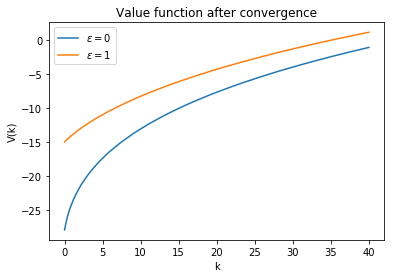

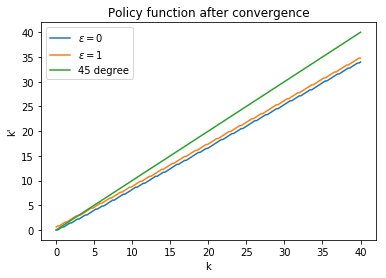

In [22]:
# import package
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import root

# define grid of values for capital k and for shock s
N = 200
k_low = 0.001
k_high = 40
k_grid = np.linspace(k_low, k_high, N)

# define parameters
beta = .96
delta = .06
alpha = .36

u = 0.1
TP = np.array([[.9, .1], [.1, .9]])
param = [alpha, beta, delta, u]
tol = 1e-8
max_iterations = 10000

# define utility function and its derivative
def u(c):
    return np.log(c)

# define rental and wage rate functions
def rr(k_bar, param):
    alpha, beta, delta, u = param
    rrf = alpha * k_bar**(alpha-1) * (1-u)**(1-alpha)
    return rrf

def wr(k_bar, param):
    alpha, beta, delta, u = param
    wrf = (1-alpha) * k_bar**alpha * (1-u)**(-alpha)
    return wrf
    
def cc(k, eps, k_bar, param):
    alpha, beta, delta, u = param
    ccf = rr(k_bar, param) + wr(k_bar, param)*eps + (1-delta)*k
    return ccf

def get_kbar(params):
    alpha, beta, delta, u = params
    f = (alpha*beta/(1 - beta*(1- delta)))**(1/(1 - alpha))
    return f

def vf_update(V_old, k_grid, k_bar, TP, param):
    V_new = np.zeros_like(V_old)
    policy = np.zeros_like(V_old)
    
    for i in range(N):
        k = k_grid[i]
        for eps in range(2):
            V_action = np.zeros_like(k_grid)
            c = cc(k,eps,k_bar,param) - k_grid
            V_action[c <= 0] = -999999
            V_action[c > 0] = u(c[c > 0]) + beta*(TP[eps,0]*V_old[0, c > 0] + TP[eps,1]*V_old[1, c > 0])
            V_new[eps,i] = max(V_action[:])
            policy[eps,i] = k_grid[np.argmax(V_action[:])]
    
    return V_new, policy

# iterate until convergence
V_old = np.zeros((2,N))
k_bar = get_kbar(param)
print("k_bar = ", k_bar)

def iterfun(V_old, k_grid, k_bar, TP, param, tol, max_iterations, graph=True):
    for iteration in range(max_iterations):
        V_new, policy_k = vf_update(V_old, k_grid, k_bar, TP, param)

        difference = np.max(abs(V_new - V_old))

        V_old = V_new.copy()

        if difference < tol:
            if graph:
                print('Converged after iteration {}'.format(iteration + 1))
                plt.figure()
                plt.plot(k_grid, V_new[0,:], label=r"$\epsilon = 0$")
                plt.plot(k_grid, V_new[1,:], label=r"$\epsilon = 1$")
                plt.xlabel('k')
                plt.ylabel('V(k)')
                plt.legend()
                plt.title('Value function after convergence')
                plt.show()

                plt.figure()
                plt.plot(k_grid, policy_k[0,:], label=r"$\epsilon = 0$")
                plt.plot(k_grid, policy_k[1,:], label=r"$\epsilon = 1$")
                plt.plot(k_grid, k_grid, label="45 degree")
                plt.xlabel('k')
                plt.ylabel("k'")
                plt.legend()
                plt.title('Policy function after convergence')
                plt.show()

            break
    return V_new, policy_k

V_new, policy_k = iterfun(V_old, k_grid, k_bar, TP, param, tol, max_iterations)

In [ ]:
# define function that simulate time series for a typical consumer
def iter_simul(V_old, k_grid, k_bar, TP, param, tol, max_iterations):
    # set seed for random number generation
    np.random.seed(0)
    Tper = 100
    k_hist = np.empty(Tper)
    kbar_old = k_bar
    
    for iteration in range(max_iterations):
        V_new, policy_k = iterfun(V_old, k_grid, k_bar, TP, param, tol, max_iterations, graph=False)
        
        k_hist[0] = np.random.choice(k_grid)
        eps_old = np.random.binomial(1,.5,1)
        for t in range(1,Tper):
            eps_new = np.random.binomial(1,TP[eps_old,0],1)
            k_hist[t] = policy_k[eps_new, np.where(k_grid == k_hist[t-1])[0]]
            eps_old = eps_new
        
        kbar_new = k_hist.mean()
        
        difference = abs(kbar_new - kbar_old)
        kbar_old = kbar_new
        
        if difference < tol:
            print('Converged after iteration {}'.format(iteration + 1))
            plt.figure()
            plt.plot(k_grid, V_new[0,:], label="Shock 1")
            plt.plot(k_grid, V_new[1,:], label="Shock 2")
            plt.xlabel('k')
            plt.ylabel('V(k)')
            plt.legend()
            plt.title('Value function after convergence')
            plt.show()

            plt.figure()
            plt.plot(k_grid, policy_k[0,:], label=r"$\epsilon = 0$")
            plt.plot(k_grid, policy_k[1,:], label=r"$\epsilon = 1$")
            plt.plot(k_grid, k_grid, label="45 degree")
            plt.xlabel('k')
            plt.ylabel("k'")
            plt.legend()
            plt.title('Policy function after convergence')
            plt.show()
            
            break
    
    return kbar_new, V_new, policy_k

k_bar, V_new, policy_k = iter_simul(V_old, k_grid, k_bar, TP, param, tol, max_iterations)
print("k_bar = ", k_bar)